In [79]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from torch.utils.data import DataLoader, TensorDataset

In [59]:
data = pd.read_csv('full_data.csv', index_col=0)

data['CattleType'] = data['CattleType'].fillna('None')

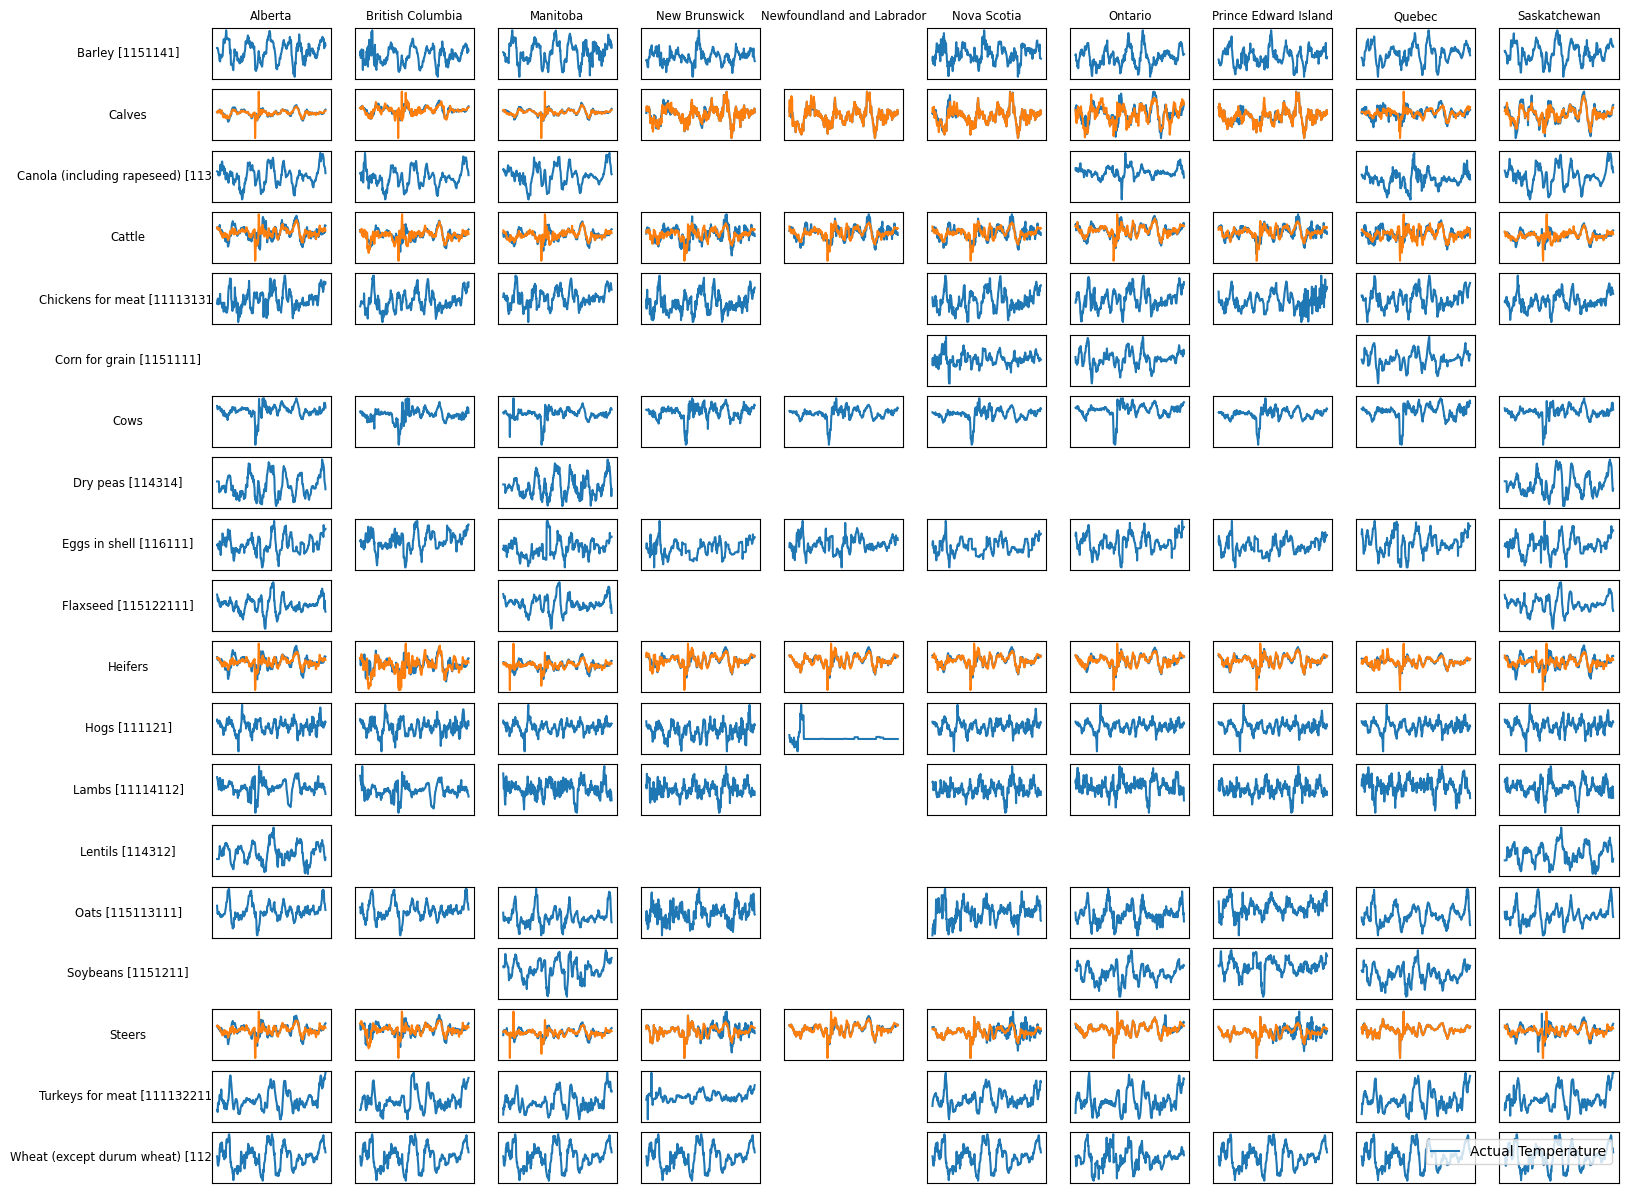

In [60]:
pivot = data.pivot_table(index='REF_DATE', columns=['GEO', 'Farm products', 'Category', 'CattleType'], values = 'YoY_change', aggfunc='first')

products = np.unique( [c[1] for c in pivot.columns] )
provinces = np.unique( [c[0] for c in pivot.columns] )

fig, axes = plt.subplots(nrows=19, ncols=11, figsize=(20, 15))

for i in range(19):
    axes[i, 0].set_xticks([])
    axes[i, 0].set_yticks([])

    for j in range(0, 11):
        axes[i, j].axis('off')

for i in range(pivot.shape[1]):
    r = np.where(products == pivot.columns[i][1])[0][0]
    c = np.where(provinces == pivot.columns[i][0])[0][0] + 1

    axes[r, c].axis('on')

    axes[r, c].plot(pivot.iloc[:, i], label='Actual Temperature')

    # Optional: Remove the x and y ticks for clarity
    axes[r, c].set_xticks([])
    axes[r, c].set_yticks([])

for j, col in enumerate(provinces):
    axes[0, j+1].set_title(col, size = 'small')

for ax, row in zip(axes[:,0], products):   
    ax.text(0.5, 0.5, row, ha='center', va='center', rotation=0, size='small')
    ax.axis('off')  # Turn off the axis for the label cells

#plt.tight_layout()
plt.legend()
plt.show()

In [65]:
other_pivot = data.pivot_table(index='REF_DATE', 
                                 columns=['GEO'], 
                                 values = ['GDP', 'Diesel', 'Gas_Regular', 'Temperature', 
                                           'Max Temperature', 'Min Temperature', 'Snowfall', 
                                           'Precipitation', 'Snow on ground at EOM', '# precipitation days', '# warm days (18C+)'], aggfunc='first')


for col, prov in other_pivot.columns:
        pivot[prov, col, 'Weather', 'None'] = other_pivot[col, prov]

y_columns = [col for col in pivot.columns if col[2] != 'Weather']

In [69]:
pivot.loc[pivot.index[4], y_columns]

GEO           Farm products                         Category  CattleType   
Alberta       Barley [1151141]                      plant     None             0.055960
              Calves                                cattle    for_feeding      0.126163
                                                              for_slaughter    0.067403
              Canola (including rapeseed) [113111]  plant     None             0.089456
              Cattle                                cattle    for_feeding      0.172608
                                                                                 ...   
Saskatchewan  Oats [115113111]                      plant     None            -0.043408
              Steers                                cattle    for_feeding      0.201562
                                                              for_slaughter    0.114730
              Turkeys for meat [111132211]          poultry   None             0.000000
              Wheat (except durum wheat) [11

In [63]:
def create_sequences(data, seq_length, y_columns):
    xs, ys = [], []
    for i in range(seq_length, len(data)):
        x = data.iloc[(i-seq_length):i]
        y = data.loc[data.index[i], y_columns]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [70]:
SEQ_LENGTH = 12
X, y = create_sequences(pivot,  SEQ_LENGTH, y_columns)

train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [82]:
pivot.shape

(360, 294)

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.LSTM(input_size, hidden_size),
            nn.ReLU(),
            nn.LSTM(hidden_size, hidden_size),
            nn.ReLU(),
            nn.LSTM(hidden_size, hidden_size),
            nn.ReLU(),
            nn.LSTM(hidden_size, hidden_size),
            nn.ReLU(),
            nn.LSTM(hidden_size, output_size)
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [86]:
test_input

tensor([[[ 5.3283e-02, -2.4559e-01, -2.0591e-01,  ..., -2.8625e+00,
          -5.0058e+00, -2.4273e+00],
         [ 1.6216e-01, -3.7979e-01, -3.0355e-01,  ...,  2.1625e+00,
          -9.1089e-02,  3.6200e+00],
         [ 1.5478e-01, -4.2971e-01, -3.5226e-01,  ...,  9.4000e+00,
           1.0717e+01,  1.2285e+01],
         ...,
         [-1.6796e-01, -2.8183e-01, -1.7986e-01,  ..., -2.5875e+00,
          -8.3364e+00, -1.5076e+01],
         [-2.0063e-01, -2.9225e-01, -2.1296e-01,  ..., -4.3286e+00,
          -8.4979e+00, -1.2985e+01],
         [-1.1760e-01, -2.9730e-01, -2.0755e-01,  ..., -5.0143e+00,
          -9.0154e+00, -9.8640e+00]],

        [[ 1.6216e-01, -3.7979e-01, -3.0355e-01,  ...,  2.1625e+00,
          -9.1089e-02,  3.6200e+00],
         [ 1.5478e-01, -4.2971e-01, -3.5226e-01,  ...,  9.4000e+00,
           1.0717e+01,  1.2285e+01],
         [-1.7588e-03, -4.4657e-01, -3.7703e-01,  ...,  1.4287e+01,
           1.5269e+01,  1.6328e+01],
         ...,
         [-2.0063e-01, -2

In [94]:
test = torch.tensor(X_train)
test.to(torch.float32)

tensor([[[ 1.3766e-01,  8.6072e-02,  9.5679e-02,  ..., -8.6687e+00,
          -1.3236e+01, -1.6555e+01],
         [ 1.3960e-01,  1.0104e-01,  6.3838e-02,  ..., -1.1663e+01,
          -1.6779e+01, -1.3101e+01],
         [ 1.3577e-01,  9.0960e-02,  1.4865e-01,  ..., -4.3063e+00,
          -6.3655e+00, -2.0798e+00],
         ...,
         [-1.7705e-01,  2.8560e-01,  1.8340e-01,  ...,  6.5200e+00,
           3.8208e+00,  3.6170e+00],
         [-2.0608e-01,  1.6447e-01,  2.1518e-01,  ...,  2.6933e+00,
          -2.1879e+00, -7.2093e+00],
         [-1.1875e-01,  1.1290e-01,  5.7851e-02,  ..., -2.3933e+00,
          -8.7182e+00, -9.6990e+00]],

        [[ 1.3960e-01,  1.0104e-01,  6.3838e-02,  ..., -1.1663e+01,
          -1.6779e+01, -1.3101e+01],
         [ 1.3577e-01,  9.0960e-02,  1.4865e-01,  ..., -4.3063e+00,
          -6.3655e+00, -2.0798e+00],
         [ 1.0379e-01,  1.0736e-01,  1.7913e-01,  ...,  2.8733e+00,
           2.8383e+00,  4.3520e+00],
         ...,
         [-2.0608e-01,  1

In [ ]:
input_size = 12 * 294  # Example input size (e.g., for MNIST dataset)
hidden_size = 100  # Number of neurons in the hidden layer
num_classes = 184  # Number of output classes (e.g., for MNIST dataset)
learning_rate = 0.01
num_epochs = 30
batch_size = 32

# Create the neural network
model = NeuralNetwork(input_size, hidden_size, num_classes)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

# Dummy data (e.g., batch of images and corresponding labels)
dummy_input = torch.tensor(X_train).to(torch.float32)
dummy_output = torch.tensor(y_train).to(torch.float32)

test_input =  torch.tensor(X_test).to(torch.float32)
test_y = torch.tensor(y_test).to(torch.float32)

# Create DataLoader for batching
train_dataset = TensorDataset(dummy_input, dummy_output)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        # Forward pass
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Learning rate scheduling
    scheduler.step()

    with torch.no_grad():
        model.eval()

        # Training step
        train_outputs = model(dummy_input)
        train_mae = mean_absolute_error(dummy_output.numpy(), train_outputs.numpy())
        train_r2 = r2_score(dummy_output.numpy(), train_outputs.numpy())

        # Testing step
        test_outputs = model(test_input)
        test_loss = criterion(test_outputs, test_y)
        test_mae = mean_absolute_error(test_y.detach().numpy(), test_outputs.detach().numpy())
        test_r2 = r2_score(test_y.detach().numpy(), test_outputs.detach().numpy())

    print(f'Epoch [{epoch+1}/{num_epochs}], '
            f'Training Loss: {loss.item():.4f}, '
            f'Test Loss: {test_loss.item():.4f}, '
            f'Training MAE: {train_mae:.4f}, '
            f'Test MAE: {test_mae:.4f}, '
            f'Training R2: {train_r2:.4f}, '
            f'Test R2: {test_r2:.4f}')

print("Training complete.")

TypeError: relu(): argument 'input' (position 1) must be Tensor, not tuple

In [77]:
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20


ValueError: Dimensions must be equal, but are 184 and 294 for '{{node compile_loss/mean_squared_error/sub}} = Sub[T=DT_FLOAT](data_1, sequential_3_1/dense_2_1/Add)' with input shapes: [?,184], [?,294].

In [107]:
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.00180e-0
Test Loss: 0.0022775311954319477


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


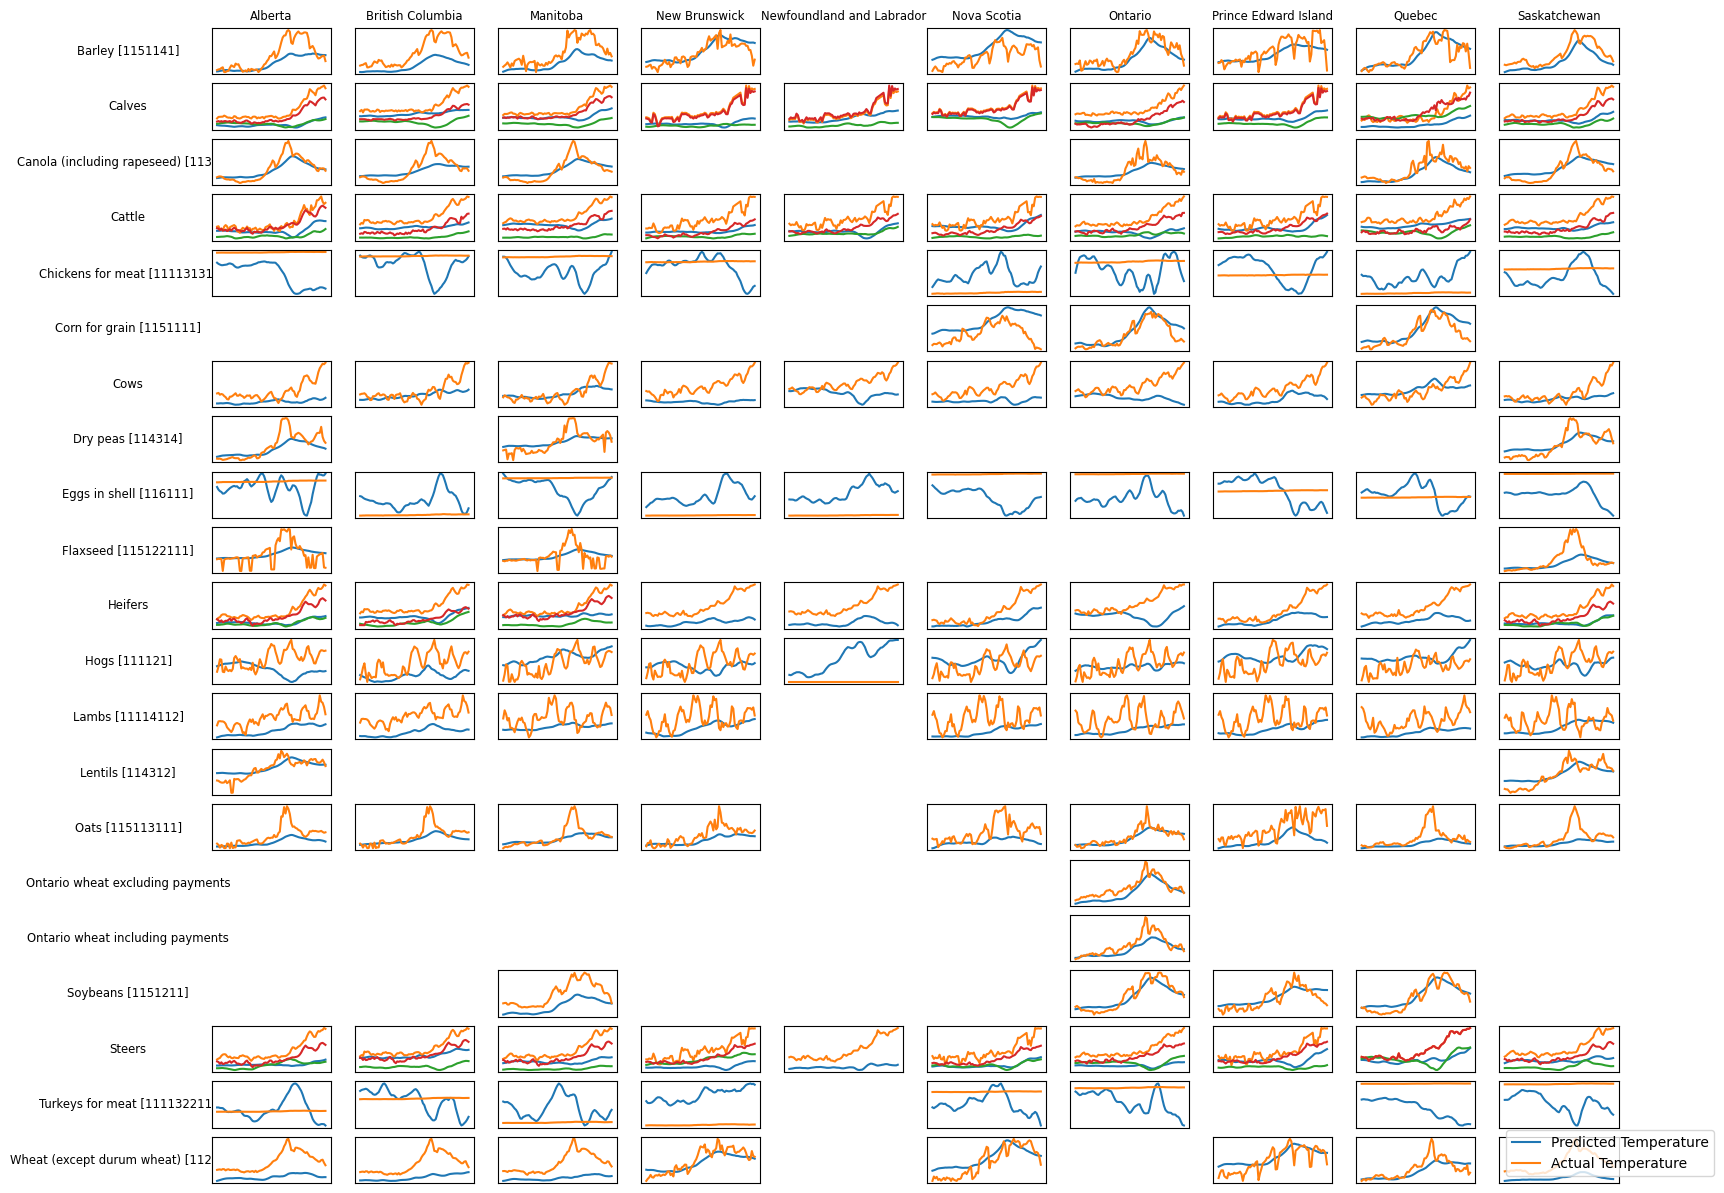

In [161]:
predictions = model.predict(X_test)

# Inverse scale the predictions
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test)

products = np.unique( [c[1] for c in data.columns] )
provinces = np.unique( [c[0] for c in data.columns] )

# Plot the results
import matplotlib.pyplot as plt
#plt.figure(figsize=(21, 15))

fig, axes = plt.subplots(nrows=21, ncols=11, figsize=(20, 15))

for i in range(21):
    axes[i, 0].set_xticks([])
    axes[i, 0].set_yticks([])

    for j in range(0, 11):
        axes[i, j].axis('off')

for i in range(predictions.shape[1]):
    r = np.where(products == data.columns[i][1])[0][0]
    c = np.where(provinces == data.columns[i][0])[0][0] + 1

    axes[r, c].axis('on')

    axes[r, c].plot(predictions[:, i], label='Predicted Temperature')
    axes[r, c].plot(y_test_scaled[:, i], label='Actual Temperature')

    # Optional: Remove the x and y ticks for clarity
    axes[r, c].set_xticks([])
    axes[r, c].set_yticks([])

for j, col in enumerate(provinces):
    axes[0, j+1].set_title(col, size = 'small')

for ax, row in zip(axes[:,0], products):   
    ax.text(0.5, 0.5, row, ha='center', va='center', rotation=0, size='small')
    ax.axis('off')  # Turn off the axis for the label cells

#plt.tight_layout()
plt.legend()
plt.show()

In [131]:
r[0][0]

0

In [79]:
y_test_scaled

array([[198.  , 177.19, 154.25, ..., 138.96, 160.58, 146.97],
       [207.99, 180.56, 156.44, ..., 134.39, 165.74, 143.91],
       [208.45, 175.59, 140.26, ..., 127.93, 174.29, 134.14],
       ...,
       [408.37, 334.77, 273.69, ..., 233.72, 319.41, 245.46],
       [414.73, 335.31, 262.13, ..., 229.08, 322.68, 240.48],
       [397.05, 323.42, 267.94, ..., 223.54, 324.87, 234.75]])

In [119]:

len(provinces)

10

In [115]:
data.columns[0]

('Alberta', 'Barley [1151141]', 'plant', 'None')

In [148]:
X

array([[[0.04661519, 0.06602557, 0.06436145, ..., 0.05081825,
         0.00060514, 0.05308077],
        [0.04687829, 0.07021548, 0.06645969, ..., 0.05053541,
         0.00061171, 0.05497555],
        [0.04749658, 0.0704457 , 0.06488766, ..., 0.05243633,
         0.00061171, 0.05637894],
        ...,
        [0.05149574, 0.07612213, 0.07098506, ..., 0.05123264,
         0.00054594, 0.05568316],
        [0.05082483, 0.07453036, 0.07200458, ..., 0.05315328,
         0.00055252, 0.05653134],
        [0.05001579, 0.06602557, 0.07355031, ..., 0.05476479,
         0.00055252, 0.05706172]],

       [[0.04687829, 0.07021548, 0.06645969, ..., 0.05053541,
         0.00061171, 0.05497555],
        [0.04749658, 0.0704457 , 0.06488766, ..., 0.05243633,
         0.00061171, 0.05637894],
        [0.04882525, 0.07118238, 0.06824221, ..., 0.05398206,
         0.00059856, 0.05640075],
        ...,
        [0.05082483, 0.07453036, 0.07200458, ..., 0.05315328,
         0.00055252, 0.05653134],
        [0.0